In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from torchinfo import summary
from torchviz import make_dot
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

In [2]:
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

In [3]:
print(conv1)

print(conv1.weight.shape)
print(conv1.bias.shape)

print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [4]:
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [5]:
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [6]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [8]:
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [9]:
outputs = features(inputs)
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [10]:
flatten = nn.Flatten()

outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


In [11]:
def eval_loss(loader, device, net, criterion):
    for images, labels in loader:
        break

    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)

    loss = criterion(outputs, labels)
    return loss

In [12]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            train_loss += loss.item()

            loss.backward()

            optimizer.step()

            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum()

            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        net.eval()
        count = 0
        
        for inputs, labels in tqdm(test_loader):
            count += len(labels)
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = torch.max(outputs, 1)[1]
            val_acc += (predicted == labels).sum()

            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    
    return history

In [13]:
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [14]:
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [15]:
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [16]:
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [17]:
data_root = '../../data'

train_set1 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform1
)

test_set1 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform1
)

train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform2
)

test_set2 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform2
)


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [18]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]
print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [19]:
batch_size = 100

train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [20]:
for images1, labels1 in train_loader1:
    break

for images2, labels2 in train_loader2:
    break

print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


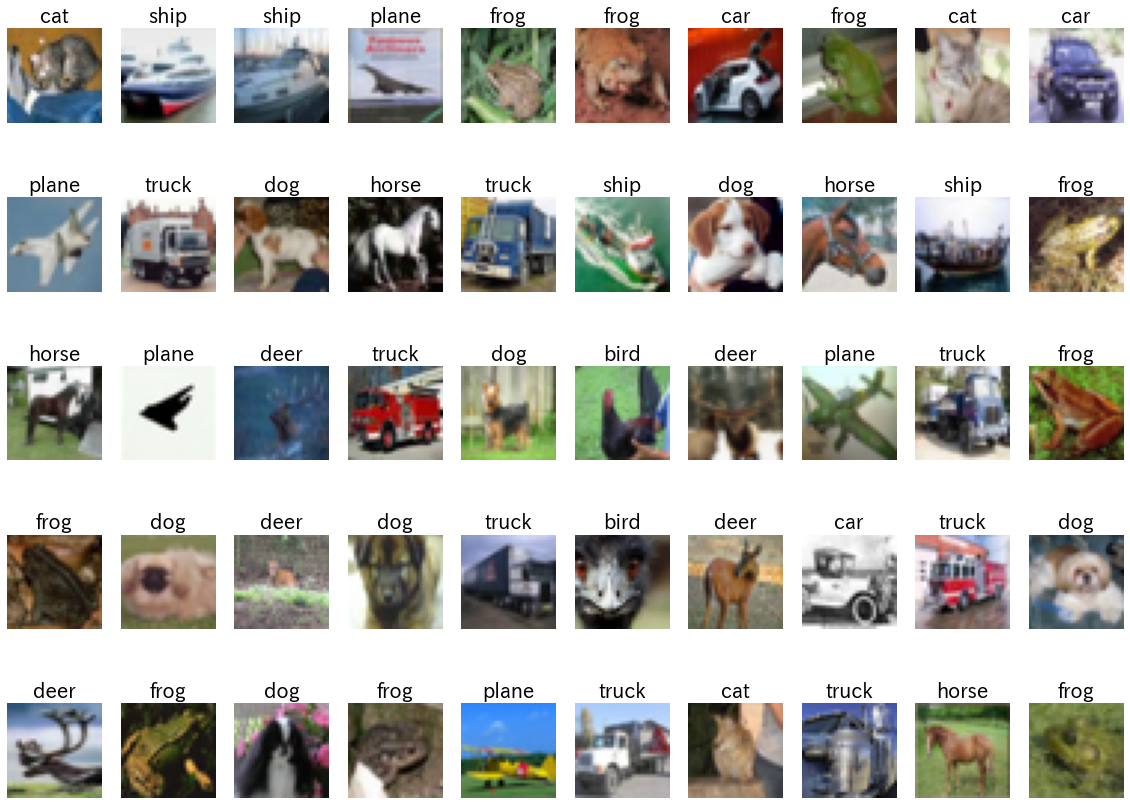

In [21]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_images_labels(test_loader2, classes, None, None)

In [22]:
n_input = image1.view(-1).shape[0]
n_output = len(set(list(labels1.data.numpy())))
n_hidden = 128

print(f'n_input: {n_input}, n_output: {n_output}, n_hidden: {n_hidden}')

n_input: 3072, n_output: 10, n_hidden: 128


In [23]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
torch_seed()

net = Net(n_input, n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)

num_epochs = 50

history = np.zeros((0, 5))
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)


Epoch [1/50], loss: 0.01950 acc: 0.32114 val_loss: 0.01795, val_acc: 0.37780



Epoch [2/50], loss: 0.01739 acc: 0.39424 val_loss: 0.01685, val_acc: 0.41890



Epoch [3/50], loss: 0.01655 acc: 0.42376 val_loss: 0.01624, val_acc: 0.43670



Epoch [4/50], loss: 0.01602 acc: 0.44202 val_loss: 0.01583, val_acc: 0.45100



Epoch [5/50], loss: 0.01564 acc: 0.45554 val_loss: 0.01555, val_acc: 0.46040



Epoch [6/50], loss: 0.01532 acc: 0.46544 val_loss: 0.01529, val_acc: 0.47010



Epoch [7/50], loss: 0.01505 acc: 0.47742 val_loss: 0.01509, val_acc: 0.47280



Epoch [8/50], loss: 0.01480 acc: 0.48686 val_loss: 0.01497, val_acc: 0.48130



Epoch [9/50], loss: 0.01457 acc: 0.49624 val_loss: 0.01476, val_acc: 0.48770



Epoch [10/50], loss: 0.01436 acc: 0.50250 val_loss: 0.01465, val_acc: 0.49100



Epoch [11/50], loss: 0.01416 acc: 0.51182 val_loss: 0.01449, val_acc: 0.49260



Epoch [12/50], loss: 0.01396 acc: 0.51940 val_loss: 0.01441, val_acc: 0.49890



Epoch [13/50], loss: 0.01378 acc: 0.52342 val_loss: 0.01428, val_acc: 0.50450



Epoch [14/50], loss: 0.01360 acc: 0.53112 val_loss: 0.01416, val_acc: 0.50790



Epoch [15/50], loss: 0.01344 acc: 0.53780 val_loss: 0.01410, val_acc: 0.50880



Epoch [16/50], loss: 0.01327 acc: 0.54368 val_loss: 0.01402, val_acc: 0.51230



Epoch [17/50], loss: 0.01311 acc: 0.54918 val_loss: 0.01396, val_acc: 0.51330



Epoch [18/50], loss: 0.01296 acc: 0.55300 val_loss: 0.01388, val_acc: 0.51730



Epoch [19/50], loss: 0.01282 acc: 0.55978 val_loss: 0.01380, val_acc: 0.51870



Epoch [20/50], loss: 0.01268 acc: 0.56468 val_loss: 0.01377, val_acc: 0.51890



Epoch [21/50], loss: 0.01255 acc: 0.57096 val_loss: 0.01370, val_acc: 0.51800



Epoch [22/50], loss: 0.01241 acc: 0.57304 val_loss: 0.01368, val_acc: 0.52060



Epoch [23/50], loss: 0.01229 acc: 0.57792 val_loss: 0.01363, val_acc: 0.52410



Epoch [24/50], loss: 0.01216 acc: 0.58330 val_loss: 0.01356, val_acc: 0.52390



Epoch [25/50], loss: 0.01205 acc: 0.58840 val_loss: 0.01350, val_acc: 0.53010



Epoch [26/50], loss: 0.01193 acc: 0.59236 val_loss: 0.01344, val_acc: 0.52950



Epoch [27/50], loss: 0.01181 acc: 0.59828 val_loss: 0.01347, val_acc: 0.52630



Epoch [28/50], loss: 0.01170 acc: 0.60092 val_loss: 0.01340, val_acc: 0.53000



Epoch [29/50], loss: 0.01159 acc: 0.60438 val_loss: 0.01339, val_acc: 0.52830



Epoch [30/50], loss: 0.01148 acc: 0.60860 val_loss: 0.01342, val_acc: 0.53070



Epoch [31/50], loss: 0.01138 acc: 0.61230 val_loss: 0.01335, val_acc: 0.53130



Epoch [32/50], loss: 0.01127 acc: 0.61720 val_loss: 0.01340, val_acc: 0.52900



Epoch [33/50], loss: 0.01117 acc: 0.61962 val_loss: 0.01338, val_acc: 0.53190



Epoch [34/50], loss: 0.01107 acc: 0.62524 val_loss: 0.01337, val_acc: 0.52970



Epoch [35/50], loss: 0.01097 acc: 0.62746 val_loss: 0.01340, val_acc: 0.52520



Epoch [36/50], loss: 0.01088 acc: 0.62980 val_loss: 0.01335, val_acc: 0.53210



Epoch [37/50], loss: 0.01079 acc: 0.63440 val_loss: 0.01332, val_acc: 0.53250



Epoch [38/50], loss: 0.01070 acc: 0.63566 val_loss: 0.01341, val_acc: 0.52900



Epoch [39/50], loss: 0.01061 acc: 0.64072 val_loss: 0.01337, val_acc: 0.52900



Epoch [40/50], loss: 0.01052 acc: 0.64198 val_loss: 0.01339, val_acc: 0.53010



Epoch [41/50], loss: 0.01043 acc: 0.64656 val_loss: 0.01339, val_acc: 0.52830



Epoch [42/50], loss: 0.01035 acc: 0.65004 val_loss: 0.01335, val_acc: 0.53340



Epoch [43/50], loss: 0.01027 acc: 0.65192 val_loss: 0.01343, val_acc: 0.52960



Epoch [44/50], loss: 0.01018 acc: 0.65608 val_loss: 0.01340, val_acc: 0.53000



Epoch [45/50], loss: 0.01010 acc: 0.65994 val_loss: 0.01343, val_acc: 0.53020



Epoch [46/50], loss: 0.01001 acc: 0.66190 val_loss: 0.01342, val_acc: 0.52960



Epoch [47/50], loss: 0.00995 acc: 0.66530 val_loss: 0.01345, val_acc: 0.52960



Epoch [48/50], loss: 0.00987 acc: 0.66622 val_loss: 0.01350, val_acc: 0.52890



Epoch [49/50], loss: 0.00979 acc: 0.66942 val_loss: 0.01341, val_acc: 0.53580



Epoch [50/50], loss: 0.00971 acc: 0.67278 val_loss: 0.01348, val_acc: 0.53140


初期状態: 損失: 0.01795 精度: 0.37780
最終状態: 損失: 0.01348 精度: 0.53140


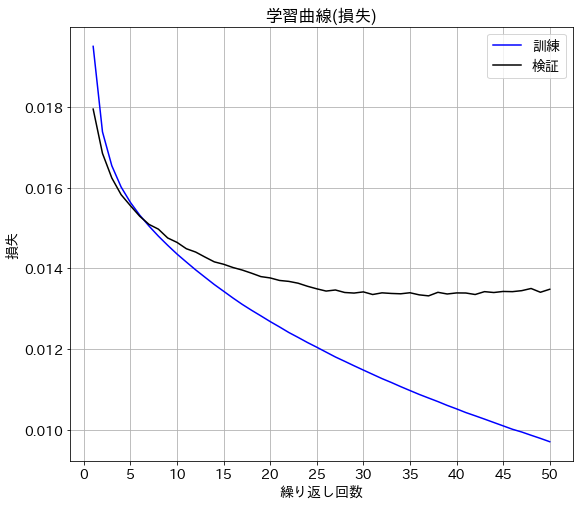

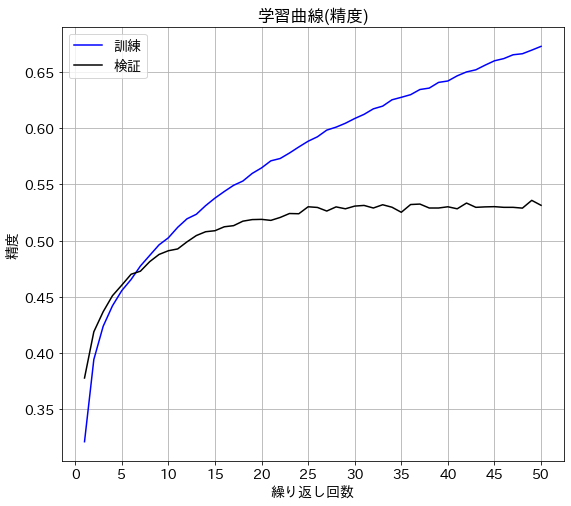

In [26]:
evaluate_history(history)

In [27]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32 ,3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [28]:
net = CNN(n_output, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [29]:
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [30]:
summary(net, (100, 3, 32, 32), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Conv2d: 1-2                            [100, 32, 30, 30]         896
├─ReLU: 1-3                              [100, 32, 30, 30]         --
├─Conv2d: 1-4                            [100, 32, 28, 28]         9,248
├─ReLU: 1-5                              [100, 32, 28, 28]         --
├─MaxPool2d: 1-6                         [100, 32, 14, 14]         --
├─Flatten: 1-7                           [100, 6272]               --
├─Sequential: 1-8                        [100, 10]                 804,234
├─Linear: 1-9                            [100, 128]                802,944
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 10]                 1,290
Total params: 814,378
Trainable params: 814,378
Non-trainable pa

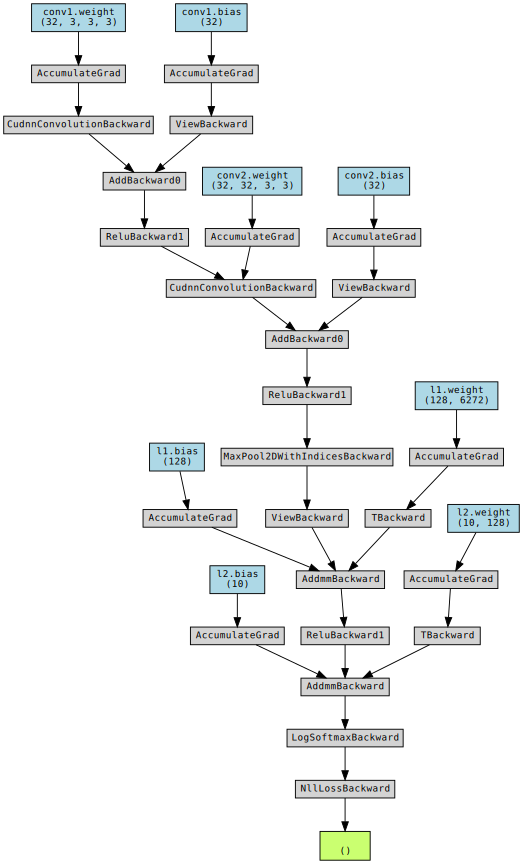

In [31]:
loss = eval_loss(test_loader2, device, net, criterion)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [32]:
torch_seed()

net = CNN(n_output, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)

num_epochs = 50

history = np.zeros((0, 5))
history = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history)


Epoch [1/50], loss: 0.02083 acc: 0.25930 val_loss: 0.01860, val_acc: 0.35180



Epoch [2/50], loss: 0.01779 acc: 0.37292 val_loss: 0.01682, val_acc: 0.40610



Epoch [3/50], loss: 0.01609 acc: 0.43070 val_loss: 0.01528, val_acc: 0.46100



Epoch [4/50], loss: 0.01484 acc: 0.47454 val_loss: 0.01425, val_acc: 0.49420



Epoch [5/50], loss: 0.01406 acc: 0.49938 val_loss: 0.01395, val_acc: 0.50100



Epoch [6/50], loss: 0.01349 acc: 0.52048 val_loss: 0.01339, val_acc: 0.52170



Epoch [7/50], loss: 0.01300 acc: 0.54032 val_loss: 0.01285, val_acc: 0.54440



Epoch [8/50], loss: 0.01253 acc: 0.55732 val_loss: 0.01266, val_acc: 0.54700



Epoch [9/50], loss: 0.01205 acc: 0.57478 val_loss: 0.01223, val_acc: 0.56370



Epoch [10/50], loss: 0.01158 acc: 0.59380 val_loss: 0.01223, val_acc: 0.56420



Epoch [11/50], loss: 0.01116 acc: 0.60834 val_loss: 0.01163, val_acc: 0.58320



Epoch [12/50], loss: 0.01074 acc: 0.62124 val_loss: 0.01140, val_acc: 0.59450



Epoch [13/50], loss: 0.01036 acc: 0.63724 val_loss: 0.01108, val_acc: 0.61090



Epoch [14/50], loss: 0.00997 acc: 0.65186 val_loss: 0.01099, val_acc: 0.61280



Epoch [15/50], loss: 0.00957 acc: 0.66436 val_loss: 0.01070, val_acc: 0.62360



Epoch [16/50], loss: 0.00919 acc: 0.67862 val_loss: 0.01049, val_acc: 0.63560



Epoch [17/50], loss: 0.00883 acc: 0.69092 val_loss: 0.01032, val_acc: 0.64030



Epoch [18/50], loss: 0.00846 acc: 0.70650 val_loss: 0.01019, val_acc: 0.64210



Epoch [19/50], loss: 0.00804 acc: 0.72190 val_loss: 0.01002, val_acc: 0.65240



Epoch [20/50], loss: 0.00773 acc: 0.73172 val_loss: 0.01011, val_acc: 0.64730



Epoch [21/50], loss: 0.00734 acc: 0.74656 val_loss: 0.00981, val_acc: 0.65960



Epoch [22/50], loss: 0.00704 acc: 0.75588 val_loss: 0.00993, val_acc: 0.65750



Epoch [23/50], loss: 0.00668 acc: 0.76710 val_loss: 0.01042, val_acc: 0.64500



Epoch [24/50], loss: 0.00635 acc: 0.78140 val_loss: 0.01005, val_acc: 0.65950



Epoch [25/50], loss: 0.00601 acc: 0.79362 val_loss: 0.01011, val_acc: 0.66330



Epoch [26/50], loss: 0.00568 acc: 0.80504 val_loss: 0.01083, val_acc: 0.64400



Epoch [27/50], loss: 0.00538 acc: 0.81650 val_loss: 0.01013, val_acc: 0.67070



Epoch [28/50], loss: 0.00506 acc: 0.82684 val_loss: 0.01038, val_acc: 0.66850



Epoch [29/50], loss: 0.00473 acc: 0.83982 val_loss: 0.01037, val_acc: 0.66910



Epoch [30/50], loss: 0.00440 acc: 0.85180 val_loss: 0.01106, val_acc: 0.65830



Epoch [31/50], loss: 0.00409 acc: 0.86276 val_loss: 0.01129, val_acc: 0.65520



Epoch [32/50], loss: 0.00381 acc: 0.87388 val_loss: 0.01133, val_acc: 0.65740



Epoch [33/50], loss: 0.00350 acc: 0.88436 val_loss: 0.01218, val_acc: 0.64590



Epoch [34/50], loss: 0.00321 acc: 0.89414 val_loss: 0.01194, val_acc: 0.65790



Epoch [35/50], loss: 0.00289 acc: 0.90704 val_loss: 0.01228, val_acc: 0.66040



Epoch [36/50], loss: 0.00269 acc: 0.91202 val_loss: 0.01242, val_acc: 0.66450



Epoch [37/50], loss: 0.00239 acc: 0.92316 val_loss: 0.01302, val_acc: 0.65720



Epoch [38/50], loss: 0.00213 acc: 0.93518 val_loss: 0.01341, val_acc: 0.65370



Epoch [39/50], loss: 0.00187 acc: 0.94322 val_loss: 0.01379, val_acc: 0.66100



Epoch [40/50], loss: 0.00163 acc: 0.95370 val_loss: 0.01474, val_acc: 0.64910



Epoch [41/50], loss: 0.00153 acc: 0.95682 val_loss: 0.01438, val_acc: 0.65980



Epoch [42/50], loss: 0.00117 acc: 0.96982 val_loss: 0.01547, val_acc: 0.65470



Epoch [43/50], loss: 0.00107 acc: 0.97336 val_loss: 0.01537, val_acc: 0.65880



Epoch [44/50], loss: 0.00088 acc: 0.98156 val_loss: 0.01626, val_acc: 0.66230



Epoch [45/50], loss: 0.00065 acc: 0.98888 val_loss: 0.01653, val_acc: 0.65920



Epoch [46/50], loss: 0.00078 acc: 0.98542 val_loss: 0.01772, val_acc: 0.65780



Epoch [47/50], loss: 0.00064 acc: 0.98822 val_loss: 0.01712, val_acc: 0.66100



Epoch [48/50], loss: 0.00039 acc: 0.99600 val_loss: 0.01773, val_acc: 0.66400



Epoch [49/50], loss: 0.00028 acc: 0.99816 val_loss: 0.01820, val_acc: 0.66480



Epoch [50/50], loss: 0.00023 acc: 0.99872 val_loss: 0.01856, val_acc: 0.66330


初期状態: 損失: 0.01860 精度: 0.35180
最終状態: 損失: 0.01856 精度: 0.66330


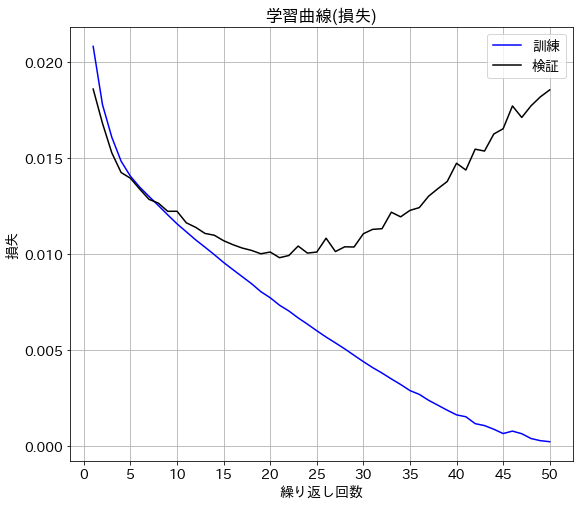

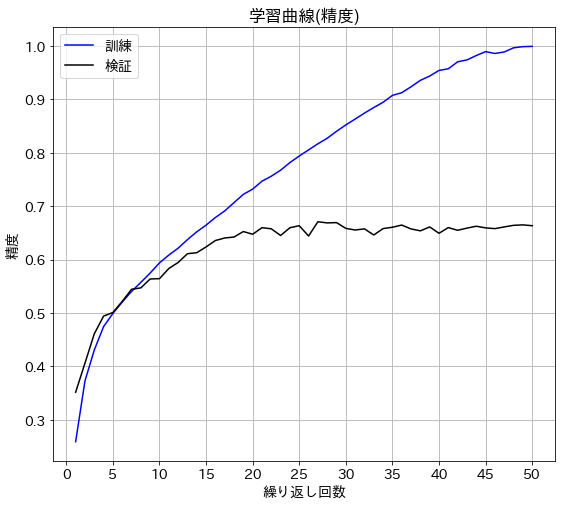

In [33]:
evaluate_history(history)

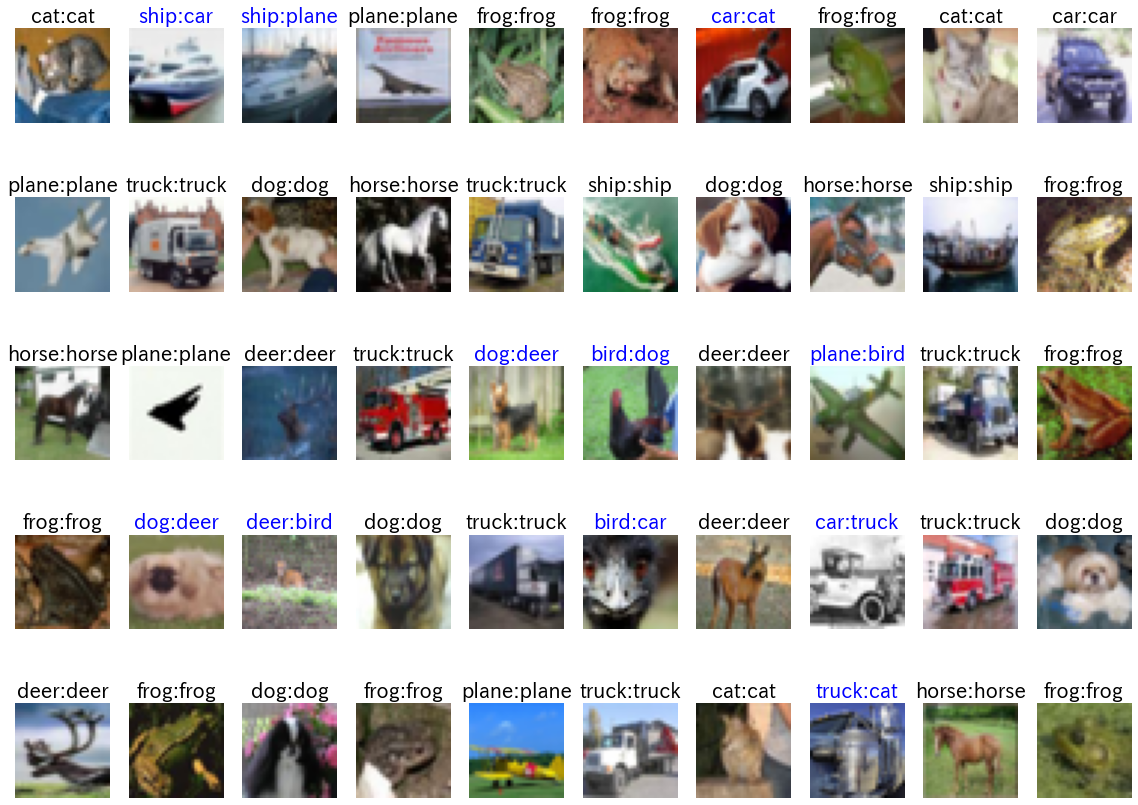

In [34]:
show_images_labels(test_loader2, classes, net, device)